In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings

# SMOTE
from imblearn.over_sampling import SMOTE

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score
from collections import Counter

# Modeller
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

# Ayarlar
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# Yollar
BASE_DIR = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(BASE_DIR, 'data', 'processed', 'wildfire_data_clean.parquet')
MODELS_DIR = os.path.join(BASE_DIR, 'results', 'models_balanced')
os.makedirs(MODELS_DIR, exist_ok=True)

print(" Kütüphaneler yüklendi, SMOTE operasyonuna hazırız!")

 Kütüphaneler yüklendi, SMOTE operasyonuna hazırız!


In [3]:
def load_and_balance_data():
    print(" Veri okunuyor...")
    df = pd.read_parquet(DATA_PATH)
    
    # Hedef ve Özellikler
    X = df.drop(columns=['FIRE_SIZE_CLASS_ID', 'FIRE_SIZE'])
    y = df['FIRE_SIZE_CLASS_ID']
    
    # 1. Önce Veriyi Böl (Stratify ile oranları koruyarak)
    print(" Veri Eğitim ve Test olarak bölünüyor...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # 2. Dengesiz Durumu Görelim
    print(f"\n📊 SMOTE Öncesi Sınıf Dağılımı (Train): {Counter(y_train)}")
    
    # 3. SMOTE Uygula 
    print("🧬 SMOTE ile azınlık sınıflar klonlanıyor...")
    smote = SMOTE(random_state=42) 
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # 4. Yeni Durumu Görelim
    print(f"SMOTE Sonrası Sınıf Dağılımı (Train): {Counter(y_train_resampled)}")
    
    return X_train_resampled, X_test, y_train_resampled, y_test

X_train_bal, X_test, y_train_bal, y_test = load_and_balance_data()

 Veri okunuyor...
 Veri Eğitim ve Test olarak bölünüyor...

📊 SMOTE Öncesi Sınıf Dağılımı (Train): Counter({1: 751501, 0: 533535, 2: 176062, 3: 22742, 4: 11285, 5: 6229, 6: 3018})
🧬 SMOTE ile azınlık sınıflar klonlanıyor...
SMOTE Sonrası Sınıf Dağılımı (Train): Counter({1: 751501, 0: 751501, 2: 751501, 3: 751501, 4: 751501, 5: 751501, 6: 751501})


 Grafik verisi hazırlanıyor...
 SMOTE Etkisi Görselleştiriliyor...


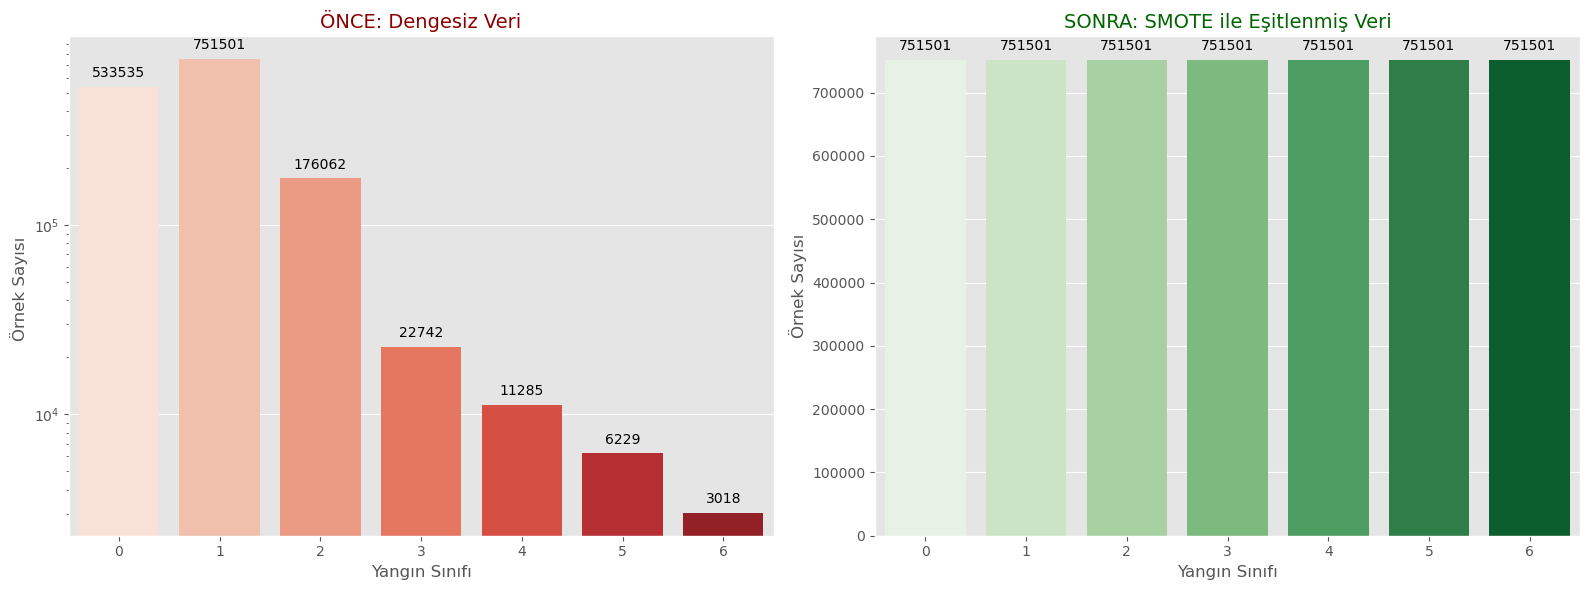

In [6]:
# 1. Eksik değişkeni (y_train) tekrar hazırlayalım
print(" Grafik verisi hazırlanıyor...")
df_temp = pd.read_parquet(DATA_PATH)
y_temp = df_temp['FIRE_SIZE_CLASS_ID']
X_temp = df_temp.drop(columns=['FIRE_SIZE_CLASS_ID', 'FIRE_SIZE'])

# Stratify ile bölüyoruz ki oranlar aynı kalsın
_, _, y_train, _ = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

# 2. Grafik Çizme Fonksiyonu
def plot_smote_effect(y_before, y_after):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Sol Grafik: SMOTE Öncesi 
    sns.countplot(x=y_before, ax=axes[0], palette="Reds")
    axes[0].set_title(f"ÖNCE: Dengesiz Veri", fontsize=14, color='darkred')
    axes[0].set_xlabel("Yangın Sınıfı")
    axes[0].set_ylabel("Örnek Sayısı ")
    axes[0].set_yscale('log') 
    
    for p in axes[0].patches:
        axes[0].annotate(f'{int(p.get_height())}', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

    # Sağ Grafik: SMOTE Sonrası 
    sns.countplot(x=y_after, ax=axes[1], palette="Greens")
    axes[1].set_title(f"SONRA: SMOTE ile Eşitlenmiş Veri", fontsize=14, color='darkgreen')
    axes[1].set_xlabel("Yangın Sınıfı")
    axes[1].set_ylabel("Örnek Sayısı")
    
  
    for p in axes[1].patches:
        axes[1].annotate(f'{int(p.get_height())}', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

    plt.tight_layout()
    plt.show()

# 3. Fonksiyonu Sadece Bir Kere Çağır
print(" SMOTE Etkisi Görselleştiriliyor...")
plot_smote_effect(y_train, y_train_bal)

In [9]:
from math import pi

# --- 1. Temel Öğrenme Eğrisi ---
def plot_learning_curve(train_loss, val_loss, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Test Loss')
    plt.title(f'{model_name} (Balanced) Learning Curve')
    plt.xlabel('Iterations')
    plt.ylabel('Log Loss')
    plt.legend()
    plt.show()

# --- 2. Radar Grafiği ---
def plot_radar_chart(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    values = [report[str(i)]['recall'] for i in range(7)]
    
    N = len(classes)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values += values[:1]
    angles += angles[:1]
    
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], classes, color='grey', size=12)
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=10)
    plt.ylim(0, 1)
    ax.plot(angles, values, linewidth=2, linestyle='solid', color='#2ca02c', label=model_name) # Yesil renk
    ax.fill(angles, values, '#2ca02c', alpha=0.2)
    plt.title(f"{model_name} - Yetenek Haritası (Balanced)", size=14, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

# --- 3. Bias Analizi (Gerçek vs Tahmin) ---
def plot_prediction_distribution(y_test, y_pred, model_name):
    df_actual = pd.DataFrame({'Class': y_test, 'Type': 'Gerçek (Actual)'})
    df_pred = pd.DataFrame({'Class': y_pred, 'Type': 'Tahmin (Predicted)'})
    df_combined = pd.concat([df_actual, df_pred])
    
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df_combined, x='Class', hue='Type', palette=['#d62728', '#2ca02c']) # Kirmizi vs Yesil
    plt.title(f'{model_name} - Gerçek vs Tahmin Dağılımı (Korkaklık Testi)')
    plt.xlabel('Yangın Sınıfı')
    plt.ylabel('Sayı (Log)')
    plt.yscale('log')
    plt.legend()
    plt.show()

# --- 4. Genel Değerlendirme Fonksiyonu ---
def evaluate_model(model, X_test, y_test, model_name):
    print(f"\n--- {model_name} (DENGELİ) ANALİZİ ---")
    y_pred = model.predict(X_test)
    
    # Metrikler
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    g_recall = report_dict.get('6', {}).get('recall', 0)
    
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"CLASS G RECALL: {g_recall:.4f}") # En kritik degerimiz bu!
    
    # Grafikleri Ciz
    plot_radar_chart(model, X_test, y_test, model_name)
    plot_prediction_distribution(y_test, y_pred, model_name)
    
    return {'Model': model_name, 'Accuracy': acc, 'F1_Score': f1, 'Class_G_Recall': g_recall}

results_balanced = []
print(" Tüm grafik fonksiyonları hafızaya yüklendi!")

 Tüm grafik fonksiyonları hafızaya yüklendi!


 LightGBM Eğitiliyor... 


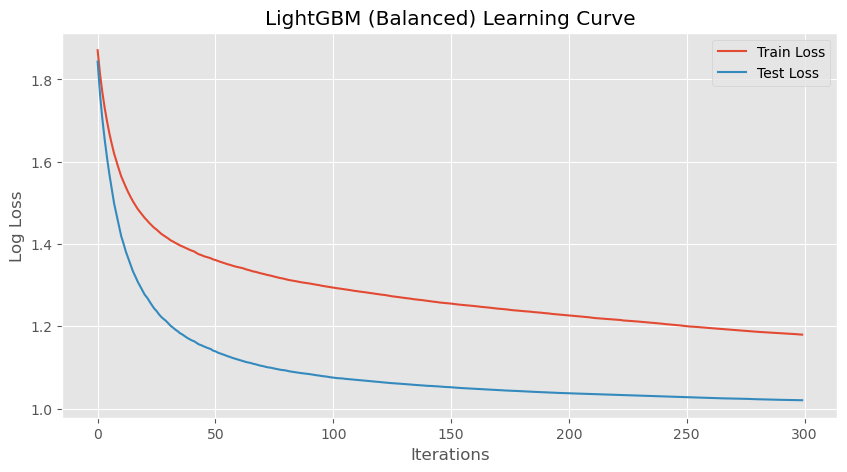


--- LightGBM (DENGELİ) ANALİZİ ---
Accuracy: 0.5948
F1 Score: 0.5878
CLASS G RECALL: 0.4291


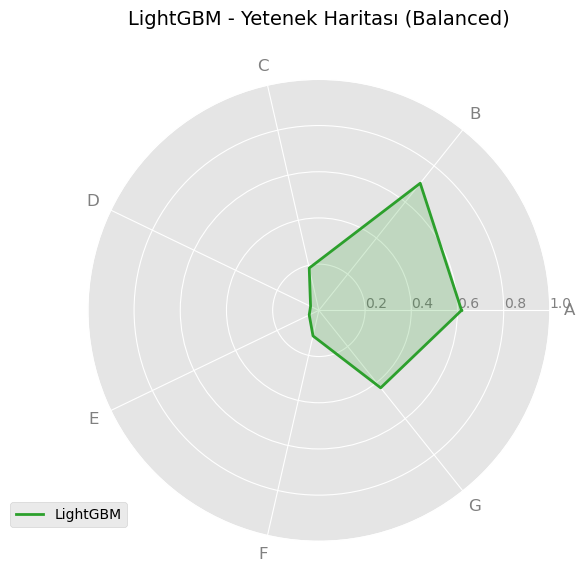

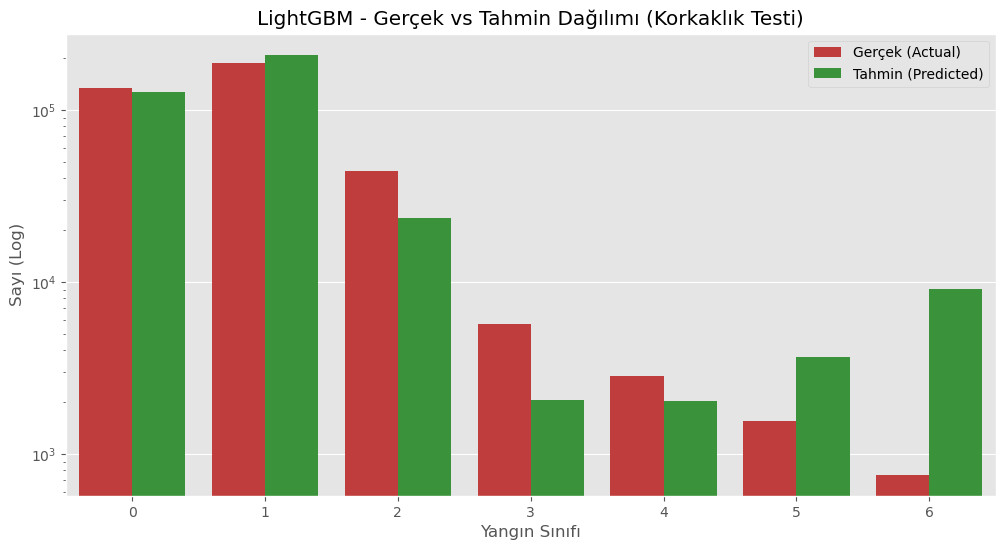

In [10]:
print(" LightGBM Eğitiliyor... ")

lgbm = LGBMClassifier(
    n_estimators=300,    
    learning_rate=0.1,
    max_depth=8,        
    n_jobs=-1,
    verbose=-1
)

lgbm.fit(
    X_train_bal, y_train_bal,
    eval_set=[(X_train_bal, y_train_bal), (X_test, y_test)],
    eval_metric="multi_logloss",
    callbacks=[]
)


results_lgbm = lgbm.evals_result_
plot_learning_curve(
    results_lgbm['training']['multi_logloss'],
    results_lgbm['valid_1']['multi_logloss'], 
    "LightGBM"
)


results_balanced.append(evaluate_model(lgbm, X_test, y_test, "LightGBM"))

In [12]:
def plot_prediction_distribution(y_test, y_pred, model_name):
    y_test_flat = np.array(y_test).ravel()
    y_pred_flat = np.array(y_pred).ravel()
    
    df_actual = pd.DataFrame({'Class': y_test_flat, 'Type': 'Gerçek (Actual)'})
    df_pred = pd.DataFrame({'Class': y_pred_flat, 'Type': 'Tahmin (Predicted)'})
    df_combined = pd.concat([df_actual, df_pred])
    
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df_combined, x='Class', hue='Type', palette=['#d62728', '#2ca02c']) 
    plt.title(f'{model_name} - Gerçek vs Tahmin Dağılımı')
    plt.xlabel('Yangın Sınıfı')
    plt.ylabel('Sayı (Log)')
    plt.yscale('log')
    plt.legend()
    plt.show()

print(" Grafik fonksiyonu CatBoost uyumlu hale getirildi!")

 Grafik fonksiyonu CatBoost uyumlu hale getirildi!


CatBoost Eğitiliyor...


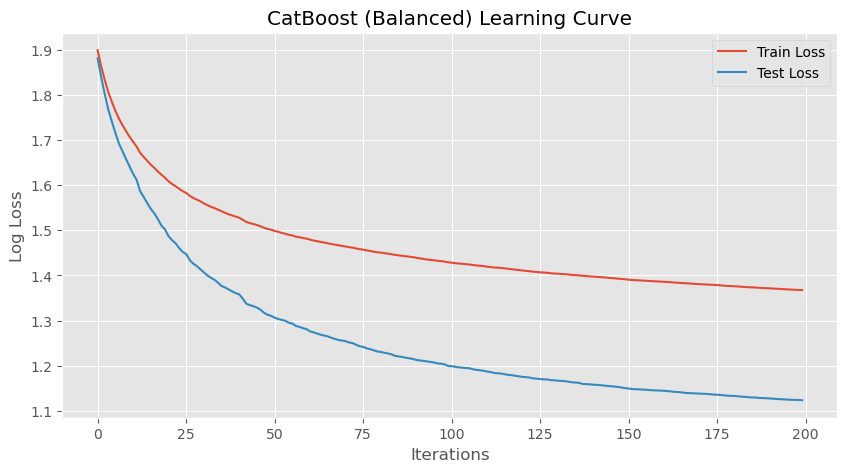


--- CatBoost (DENGELİ) ANALİZİ ---
Accuracy: 0.5652
F1 Score: 0.5631
CLASS G RECALL: 0.5073


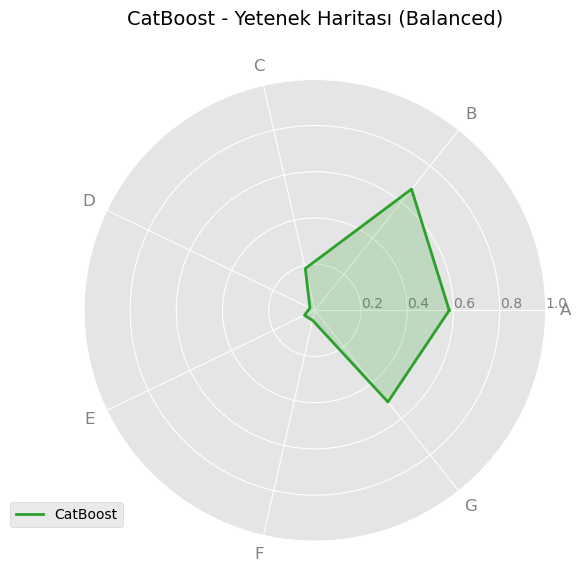

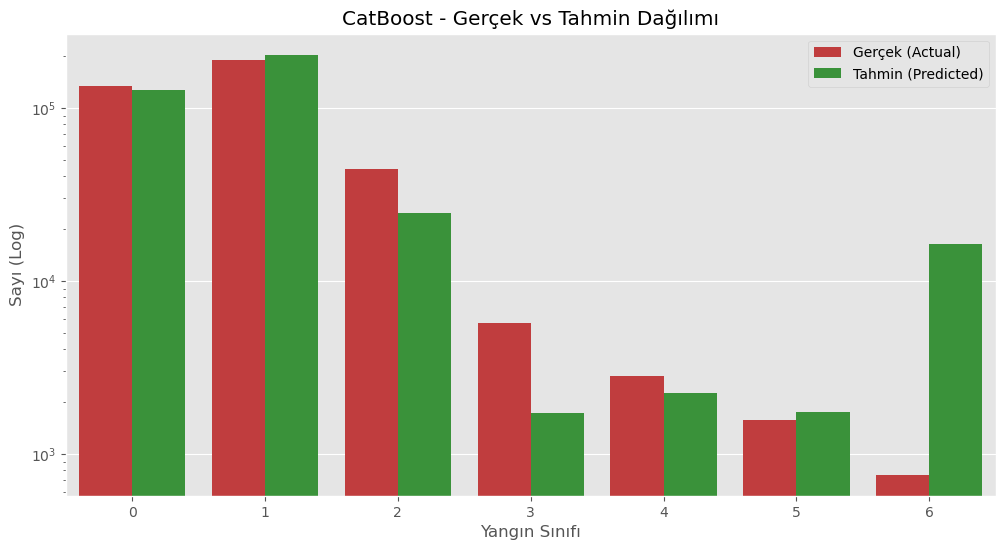

In [13]:
print("CatBoost Eğitiliyor...")

cat = CatBoostClassifier(
    iterations=200, 
    depth=6, 
    learning_rate=0.1, 
    loss_function='MultiClass',
    verbose=False,
    allow_writing_files=False
)

cat.fit(
    X_train_bal, y_train_bal, 
    eval_set=(X_test, y_test), 
    verbose=False,
    plot=False
)

# Grafik Çizimi
try:
    res = cat.get_evals_result()
    plot_learning_curve(
        res['learn']['MultiClass'],
        res['validation']['MultiClass'],
        "CatBoost"
    )
except:
    print("Grafik çizilemedi.")

# Detaylı Analiz
results_balanced.append(evaluate_model(cat, X_test, y_test, "CatBoost"))

Random Forest Eğitiliyor...

--- Random Forest (DENGELİ) ANALİZİ ---
Accuracy: 0.5052
F1 Score: 0.5307
CLASS G RECALL: 0.5417


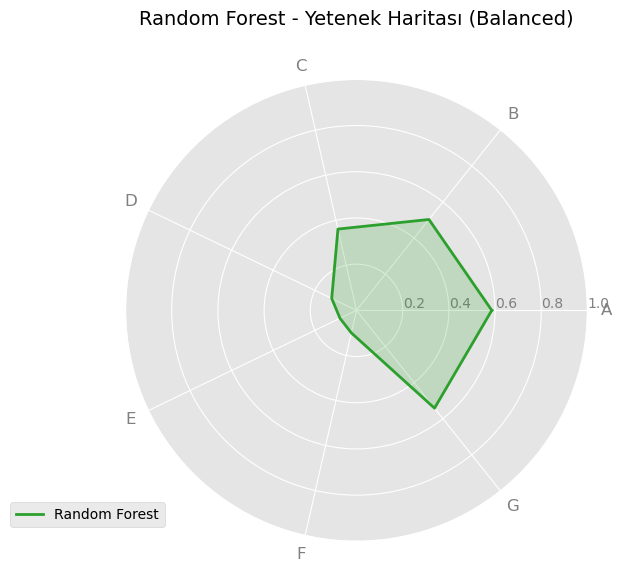

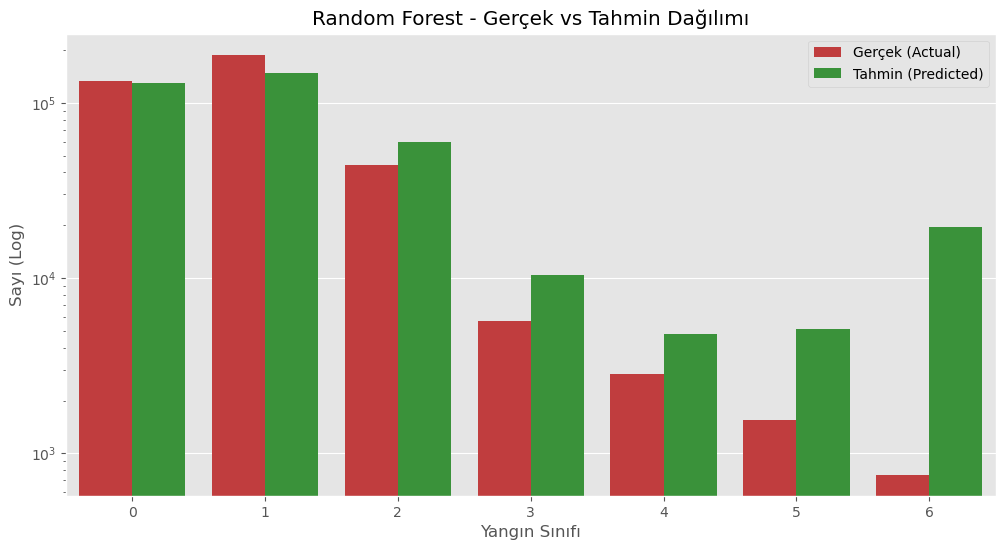

In [14]:
print("Random Forest Eğitiliyor...")

rf = RandomForestClassifier(
    n_estimators=50, 
    max_depth=10, 
    n_jobs=-1, 
    random_state=42
)
rf.fit(X_train_bal, y_train_bal)
results_balanced.append(evaluate_model(rf, X_test, y_test, "Random Forest"))

In [15]:
# Sonuçları DataFrame yap
df_results_bal = pd.DataFrame(results_balanced)
df_results_bal = df_results_bal.sort_values(by='Class_G_Recall', ascending=False)

print(" DENGELİ EĞİTİM LİDERLİK TABLOSU:")
display(df_results_bal)

# Sonuçları Kaydet
df_results_bal.to_csv(os.path.join(MODELS_DIR, 'balanced_results_final.csv'), index=False)

 DENGELİ EĞİTİM LİDERLİK TABLOSU:


,Model,Accuracy,F1_Score,Class_G_Recall
2,Random Forest,0.505165,0.530668,0.541722
1,CatBoost,0.565233,0.563097,0.507285
0,LightGBM,0.594837,0.587801,0.429139


In [20]:
!pip install optuna

In [17]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import recall_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
import os


def objective(trial):
    
    # 1. Hiperparametre Uzayi
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'loss_function': 'MultiClass',
        'verbose': False,
        'allow_writing_files': False,
        'task_type': 'CPU'
    }

    # 2. Modeli Kur ve Egit
    model = CatBoostClassifier(**param)
    
    # Egitim 
    model.fit(
        X_train_bal, y_train_bal,
        eval_set=[(X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False
    )

    # 3. Basariyi Olc
    preds = model.predict(X_test)
    f1 = f1_score(y_test, preds, average='macro')
    
    return f1

# --- OPTIMIZASYONU BASLAT ---
print(" Optuna ile en iyi ayarlar aranıyor...")
study = optuna.create_study(direction='maximize') 
study.optimize(objective, n_trials=20) 

print(f"\n En İyi Skor: {study.best_value:.4f}")
print(" En İyi Parametreler:")
print(study.best_params)

[I 2025-12-30 23:45:20,879] A new study created in memory with name: no-name-2e5638aa-d7ff-4d4b-bb79-726a19404b4d


 Optuna ile en iyi ayarlar aranıyor...


[I 2025-12-30 23:56:50,786] Trial 0 finished with value: 0.2649664145382184 and parameters: {'iterations': 857, 'depth': 9, 'learning_rate': 0.24822631889131255, 'random_strength': 32, 'bagging_temperature': 0.42970160920665124, 'l2_leaf_reg': 5.715682043092837}. Best is trial 0 with value: 0.2649664145382184.
[I 2025-12-31 00:00:23,807] Trial 1 finished with value: 0.24627201587061945 and parameters: {'iterations': 800, 'depth': 4, 'learning_rate': 0.15712683257063126, 'random_strength': 19, 'bagging_temperature': 0.6636666544725665, 'l2_leaf_reg': 1.0561185593575246}. Best is trial 0 with value: 0.2649664145382184.
[I 2025-12-31 00:04:16,877] Trial 2 finished with value: 0.25017809561324683 and parameters: {'iterations': 805, 'depth': 5, 'learning_rate': 0.16039317105494152, 'random_strength': 56, 'bagging_temperature': 0.4749270614897304, 'l2_leaf_reg': 4.141914318449232}. Best is trial 0 with value: 0.2649664145382184.
[I 2025-12-31 00:06:30,280] Trial 3 finished with value: 0.2441


 En İyi Skor: 0.2650
 En İyi Parametreler:
{'iterations': 857, 'depth': 9, 'learning_rate': 0.24822631889131255, 'random_strength': 32, 'bagging_temperature': 0.42970160920665124, 'l2_leaf_reg': 5.715682043092837}


 OPTUNA ŞAMPİYONU EĞİTİLİYOR...
Parametreler: {'iterations': 857, 'depth': 9, 'learning_rate': 0.24822631889131255, 'random_strength': 32, 'bagging_temperature': 0.42970160920665124, 'l2_leaf_reg': 5.715682043092837, 'loss_function': 'MultiClass', 'verbose': False, 'allow_writing_files': False, 'task_type': 'CPU'}
 Eğitim Başladı...

 --- FİNAL MODEL PERFORMANSI ---

--- CatBoost_Final_Optimized (DENGELİ) ANALİZİ ---
Accuracy: 0.5957
F1 Score: 0.5916
CLASS G RECALL: 0.3603


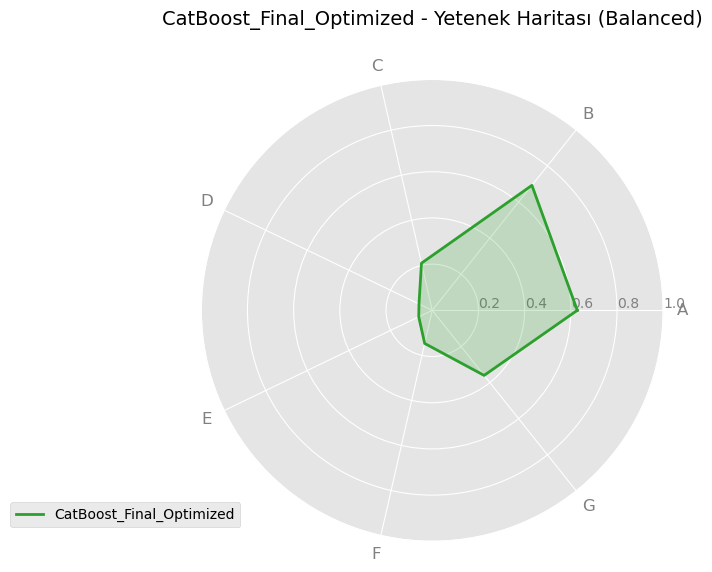

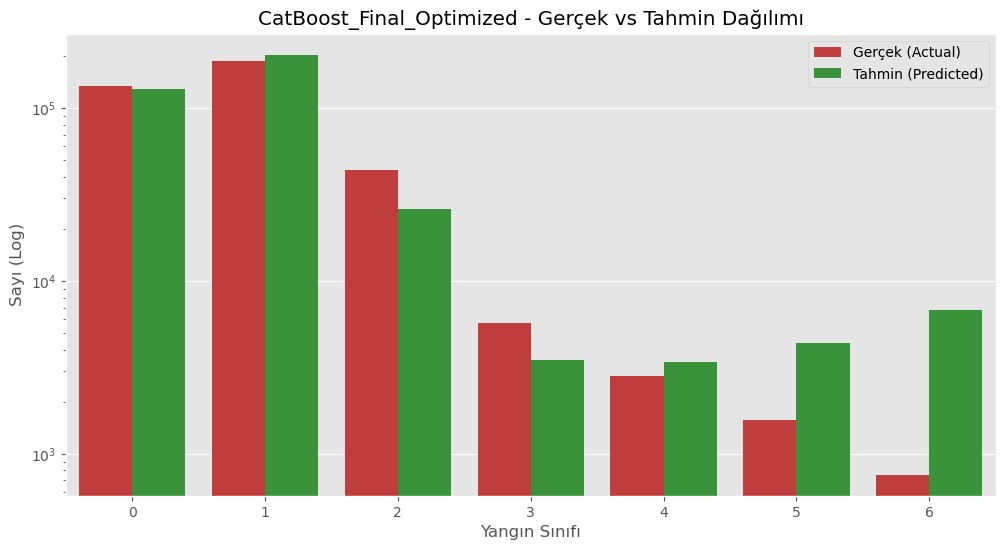

--------------------------------------------------
 MÜKEMMEL! Model başarıyla kaydedildi: /Users/memra/Desktop/Wildfire_AI_Project/results/models_balanced/catboost_final_model.cbm


In [19]:
# 1.ŞAMPİYON PARAMETRELER 
final_params = {
    'iterations': 857,
    'depth': 9,
    'learning_rate': 0.24822631889131255,
    'random_strength': 32,
    'bagging_temperature': 0.42970160920665124,
    'l2_leaf_reg': 5.715682043092837,
    'loss_function': 'MultiClass', 
    'verbose': False,
    'allow_writing_files': False,
    'task_type': 'CPU'
}

print(f" OPTUNA ŞAMPİYONU EĞİTİLİYOR...")
print(f"Parametreler: {final_params}")

# 2. Şampiyon Modeli Kur 
final_model = CatBoostClassifier(**final_params)

# 3. Eğitim
print(" Eğitim Başladı...")
final_model.fit(
    X_train_bal, y_train_bal,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=50,
    verbose=False
)

# 4. Sonuçları Görselleştir 
print("\n --- FİNAL MODEL PERFORMANSI ---")
evaluate_model(final_model, X_test, y_test, "CatBoost_Final_Optimized")

# 5. Modeli Diske Kaydet 
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)

model_path = os.path.join(MODELS_DIR, 'catboost_final_model.cbm')
final_model.save_model(model_path)

print("-" * 50)
print(f" MÜKEMMEL! Model başarıyla kaydedildi: {model_path}")

 Özellik Önemi Analiz Ediliyor...


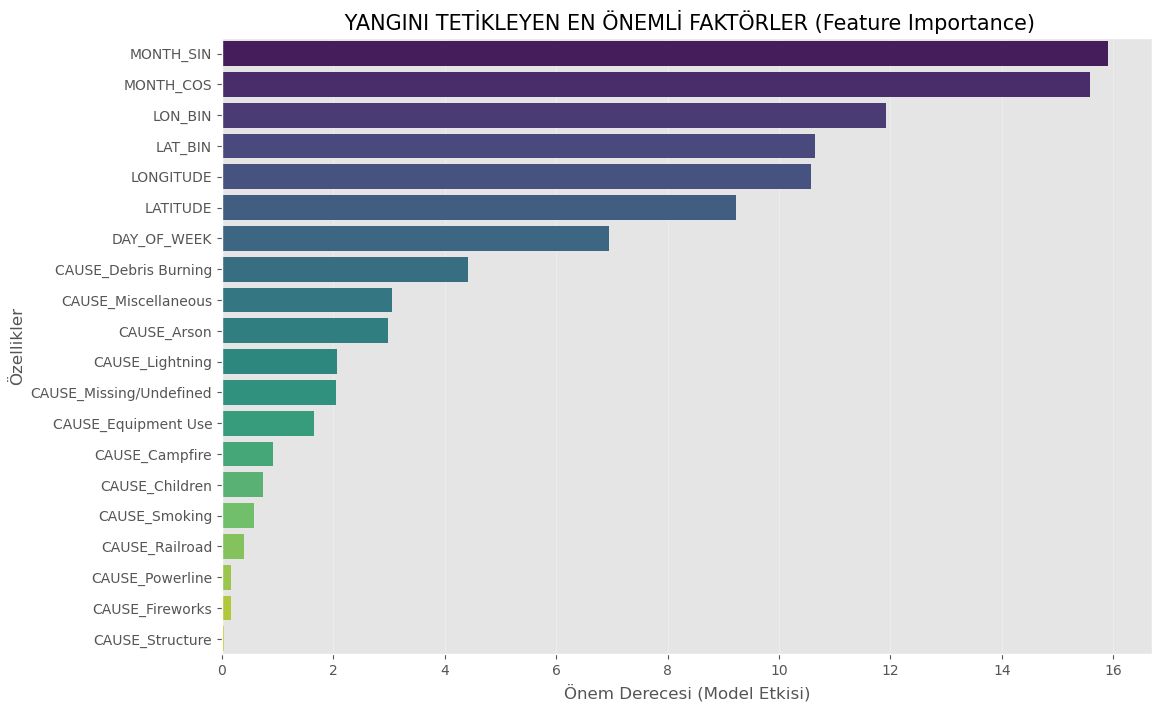

 Yüzdelik Hata Analizi Çiziliyor...


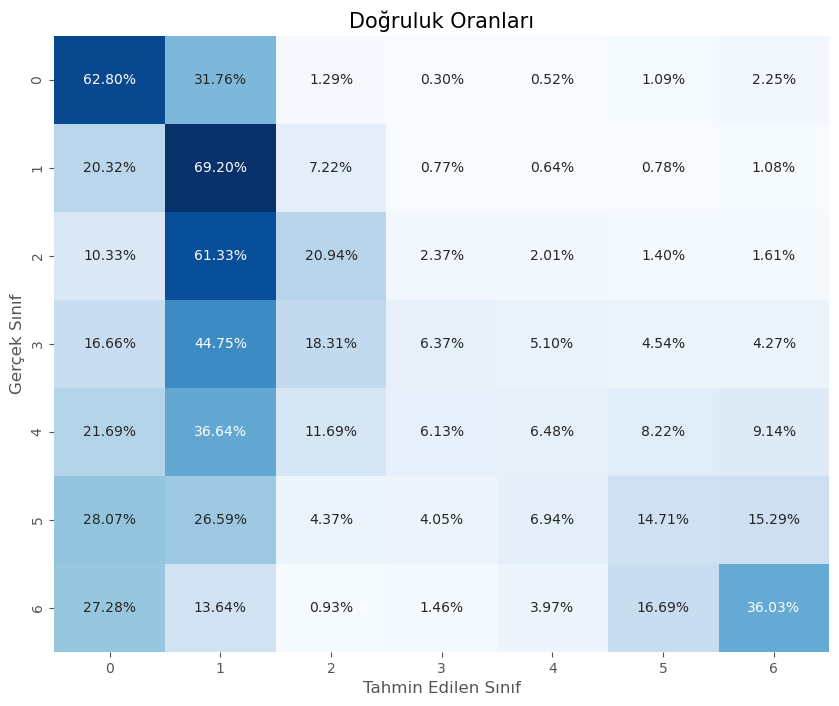

In [21]:
# --- 1. FEATURE IMPORTANCE  ---
def plot_feature_importance(model, X_data):
    feature_importance = model.get_feature_importance()
    feature_names = X_data.columns
    
    fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    fi_df = fi_df.sort_values(by='Importance', ascending=False).head(20) 
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
    plt.title(' YANGINI TETİKLEYEN EN ÖNEMLİ FAKTÖRLER (Feature Importance)', fontsize=15)
    plt.xlabel('Önem Derecesi (Model Etkisi)')
    plt.ylabel('Özellikler')
    plt.grid(True, axis='x', alpha=0.3)
    plt.show()

print(" Özellik Önemi Analiz Ediliyor...")
plot_feature_importance(final_model, X_test)


# --- 2. NORMALIZE EDİLMİŞ CONFUSION MATRIX ( ---
def plot_normalized_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, normalize='true') 
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', cbar=False)
    plt.title('Doğruluk Oranları', fontsize=15)
    plt.ylabel('Gerçek Sınıf')
    plt.xlabel('Tahmin Edilen Sınıf')
    plt.show()

print(" Yüzdelik Hata Analizi Çiziliyor...")
y_pred_final = final_model.predict(X_test)
plot_normalized_cm(y_test, y_pred_final)

In [22]:
# Modelin eğitimde kullandığı sütunların tam sırasını öğrenelim
print("SÜTUN LİSTESİ :")
cols = list(X_train_bal.columns)
print(cols)

SÜTUN LİSTESİ :
['LATITUDE', 'LONGITUDE', 'DAY_OF_WEEK', 'MONTH_SIN', 'MONTH_COS', 'CAUSE_Arson', 'CAUSE_Campfire', 'CAUSE_Children', 'CAUSE_Debris Burning', 'CAUSE_Equipment Use', 'CAUSE_Fireworks', 'CAUSE_Lightning', 'CAUSE_Miscellaneous', 'CAUSE_Missing/Undefined', 'CAUSE_Powerline', 'CAUSE_Railroad', 'CAUSE_Smoking', 'CAUSE_Structure', 'LAT_BIN', 'LON_BIN']
